In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import ket2dm, expect, mesolve

from quantum_system import (
    steady_state_from_params,
    build_hamiltonian,
    build_c_ops,
    evolve_step,
    rho_random,
    rho_iss,
    rho_list,
    sz_L,
    sz_R,
    sx_L,
    sx_R,
)
from entanglement_measures import (
    concurrence,
    negativity,
    log_negativity,
)

/home/maxime/miniconda3/envs/qrc_env/lib/python3.14/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [1]:
# ============================================
# STATIC REGIME: Steady State Analysis
# ============================================

# Define system parameters
params = {
    "eps_L": 1.0,
    "eps_R": 1.0,
    "U": 0.0,
    "g_res": 0.01,
    "g_off": 0.0,
    "f_L": 0.0,
    "f_R": 0.0,
    "gamma_L_plus": 0.01,
    "gamma_L_minus": 0.05,
    "gamma_R_plus": 0.05,
    "gamma_R_minus": 0.01,
    "gamma_z_L": 0.001,
    "gamma_z_R": 0.001,
}

# Compute steady state
rho_ss = steady_state_from_params(params)
print("Steady-state density matrix:")
print(rho_ss)
print(f"\nTrace: {rho_ss.tr():.6f}")
print(f"Purity: {(rho_ss * rho_ss).tr():.6f}")



NameError: name 'steady_state_from_params' is not defined

In [ ]:
# Steady-state properties
print("Steady-state populations:")
print(f"  |00⟩: {rho_ss[0,0].real:.6f}")
print(f"  |01⟩: {rho_ss[1,1].real:.6f}")
print(f"  |10⟩: {rho_ss[2,2].real:.6f}")
print(f"  |11⟩: {rho_ss[3,3].real:.6f}")

print("\nSteady-state observables:")
print(f"  <σ_z^L>: {expect(sz_L, rho_ss):.6f}")
print(f"  <σ_z^R>: {expect(sz_R, rho_ss):.6f}")
print(f"  <σ_x^L>: {expect(sx_L, rho_ss):.6f}")
print(f"  <σ_x^R>: {expect(sx_R, rho_ss):.6f}")

print("\nSteady-state entanglement:")
print(f"  Concurrence: {concurrence(rho_ss):.6f}")
print(f"  Negativity: {negativity(rho_ss):.6f}")
print(f"  Log-negativity: {log_negativity(rho_ss):.6f}")

Steady-state populations:
  |00⟩: 0.149371
  |01⟩: 0.048742
  |10⟩: 0.652516
  |11⟩: 0.149371

Steady-state observables:
  <σ_z^L>: -0.603774
  <σ_z^R>: 0.603774
  <σ_x^L>: 0.000000
  <σ_x^R>: 0.000000

Steady-state entanglement:
  Concurrence: 0.000000
  Negativity: 0.000000
  Log-negativity: 0.000000


In [ ]:
# ============================================
# DYNAMICAL REGIME: Time Evolution
# ============================================

# Use same parameters as static case
# Start from initial state |00⟩⟨00|
#rho = rho_random()
#rho = rho_list["mixed"]
#rho = rho_list["all"]
rho = rho_list["00"]
print(f"Initial state: {rho}")
print(f"Initial <σ_z^L>: {expect(sz_L, rho):.6f}")
print(f"Initial <σ_z^R>: {expect(sz_R, rho):.6f}")

# Build Hamiltonian and collapse operators
H = build_hamiltonian(params)
c_ops = build_c_ops(params)

# Time evolution parameters
dt = 0.1  # Time step
t_final = 30.0  # Final time
tlist = np.linspace(0, t_final, int(t_final/dt) + 1)

# Evolve the system
result = mesolve(H, rho, tlist, c_ops=c_ops, options={"store_states": True})

print(f"\nEvolved {len(tlist)} time steps from t=0 to t={t_final}")
print(f"Final state purity: {(result.states[-1] * result.states[-1]).tr():.6f}")
print(f"Steady-state purity: {(rho_ss * rho_ss).tr():.6f}")
print(f"\nConvergence check (final vs steady state):")
print(f"  Trace distance: {((result.states[-1] - rho_ss) * (result.states[-1] - rho_ss).dag()).tr().real:.6f}")

Initial state: Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Initial <σ_z^L>: 1.000000
Initial <σ_z^R>: 1.000000

Evolved 301 time steps from t=0 to t=30.0
Final state purity: 0.433256
Steady-state purity: 0.490576

Convergence check (final vs steady state):
  Trace distance: 0.022825


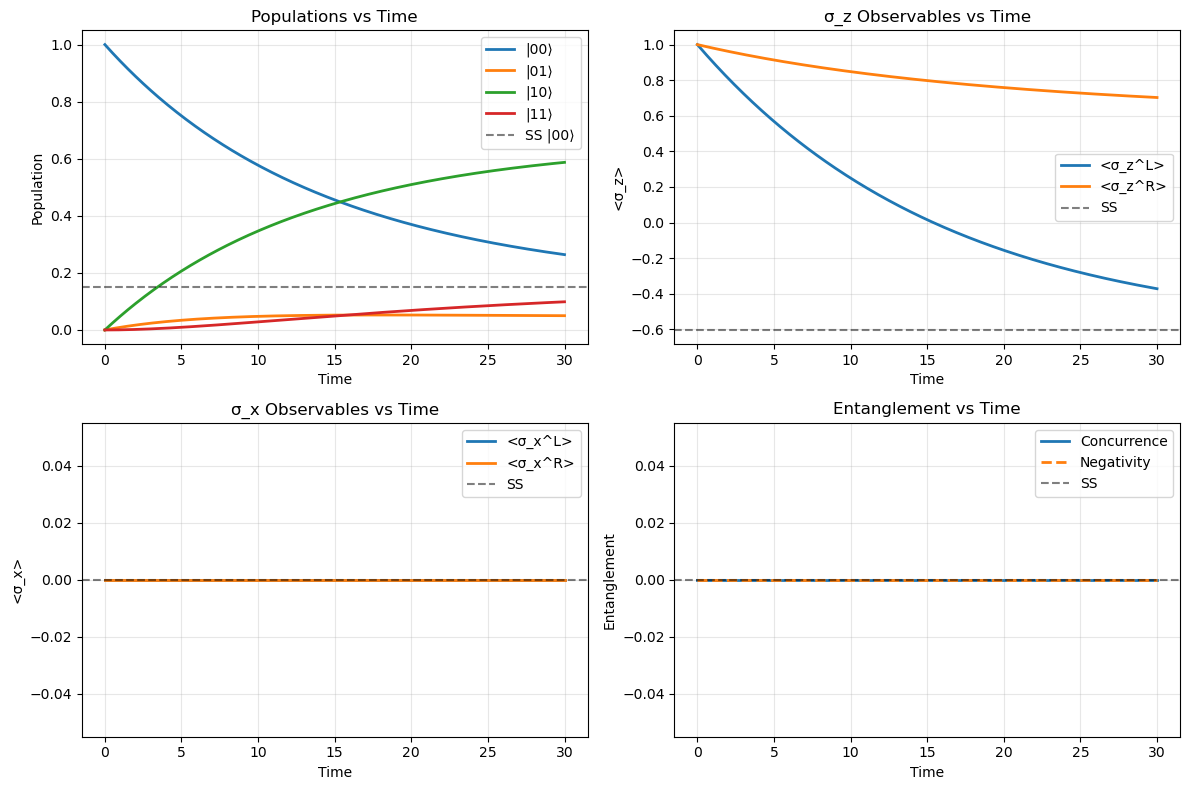

In [ ]:
# Extract observables over time
sz_L_t = [expect(sz_L, rho_t) for rho_t in result.states]
sz_R_t = [expect(sz_R, rho_t) for rho_t in result.states]
sx_L_t = [expect(sx_L, rho_t) for rho_t in result.states]
sx_R_t = [expect(sx_R, rho_t) for rho_t in result.states]

# Populations over time
pop_00 = [rho_t[0,0].real for rho_t in result.states]
pop_01 = [rho_t[1,1].real for rho_t in result.states]
pop_10 = [rho_t[2,2].real for rho_t in result.states]
pop_11 = [rho_t[3,3].real for rho_t in result.states]

# Entanglement over time
conc_t = [concurrence(rho_t) for rho_t in result.states]
neg_t = [negativity(rho_t) for rho_t in result.states]

# Plot observables
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Populations
axes[0, 0].plot(tlist, pop_00, label='|00⟩', linewidth=2)
axes[0, 0].plot(tlist, pop_01, label='|01⟩', linewidth=2)
axes[0, 0].plot(tlist, pop_10, label='|10⟩', linewidth=2)
axes[0, 0].plot(tlist, pop_11, label='|11⟩', linewidth=2)
axes[0, 0].axhline(y=rho_ss[0,0].real, color='k', linestyle='--', alpha=0.5, label='SS |00⟩')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Population')
axes[0, 0].set_title('Populations vs Time')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# σ_z observables
axes[0, 1].plot(tlist, sz_L_t, label='<σ_z^L>', linewidth=2)
axes[0, 1].plot(tlist, sz_R_t, label='<σ_z^R>', linewidth=2)
axes[0, 1].axhline(y=expect(sz_L, rho_ss), color='k', linestyle='--', alpha=0.5, label='SS')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('<σ_z>')
axes[0, 1].set_title('σ_z Observables vs Time')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# σ_x observables
axes[1, 0].plot(tlist, sx_L_t, label='<σ_x^L>', linewidth=2)
axes[1, 0].plot(tlist, sx_R_t, label='<σ_x^R>', linewidth=2)
axes[1, 0].axhline(y=expect(sx_L, rho_ss), color='k', linestyle='--', alpha=0.5, label='SS')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('<σ_x>')
axes[1, 0].set_title('σ_x Observables vs Time')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Entanglement measures
axes[1, 1].plot(tlist, conc_t, label='Concurrence', linewidth=2)
axes[1, 1].plot(tlist, neg_t, label='Negativity', linewidth=2, linestyle='--')
axes[1, 1].axhline(y=concurrence(rho_ss), color='k', linestyle='--', alpha=0.5, label='SS')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Entanglement')
axes[1, 1].set_title('Entanglement vs Time')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Testing piecewise evolution with evolve_step()...
Final <σ_z^L> from mesolve: -0.372026
Final <σ_z^L> from evolve_step: 0.249720
Difference: 6.217459e-01


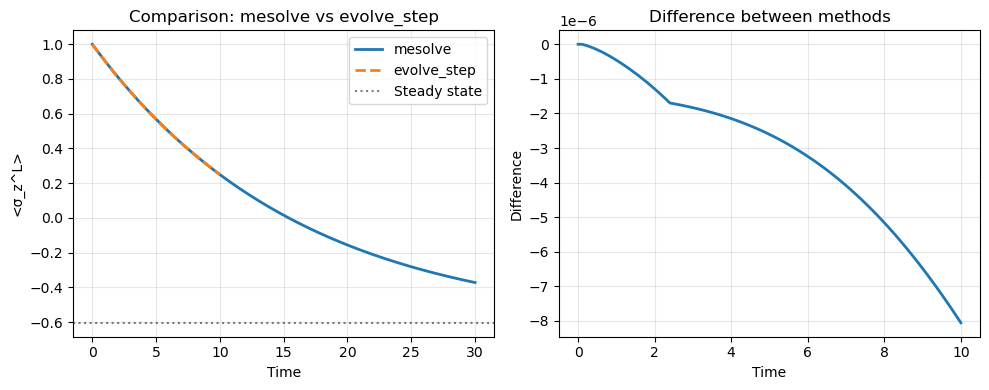

In [ ]:
# Test piecewise evolution using evolve_step
print("Testing piecewise evolution with evolve_step()...")

# Reset to initial state
rho_piecewise = rho
dt_step = 0.1
n_steps = 100

# Store states
states_piecewise = [rho_piecewise]
sz_L_piecewise = [expect(sz_L, rho_piecewise)]

for i in range(n_steps):
    rho_piecewise = evolve_step(H, c_ops, rho_piecewise, dt_step)
    states_piecewise.append(rho_piecewise)
    sz_L_piecewise.append(expect(sz_L, rho_piecewise))

t_piecewise = np.linspace(0, n_steps * dt_step, n_steps + 1)

# Compare with mesolve
print(f"Final <σ_z^L> from mesolve: {sz_L_t[-1]:.6f}")
print(f"Final <σ_z^L> from evolve_step: {sz_L_piecewise[-1]:.6f}")
print(f"Difference: {abs(sz_L_t[-1] - sz_L_piecewise[-1]):.6e}")

# Plot comparison
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(tlist, sz_L_t, label='mesolve', linewidth=2)
plt.plot(t_piecewise, sz_L_piecewise, label='evolve_step', linewidth=2, linestyle='--')
plt.axhline(y=expect(sz_L, rho_ss), color='k', linestyle=':', alpha=0.5, label='Steady state')
plt.xlabel('Time')
plt.ylabel('<σ_z^L>')
plt.title('Comparison: mesolve vs evolve_step')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
diff = np.array(sz_L_t[:len(sz_L_piecewise)]) - np.array(sz_L_piecewise)
plt.plot(t_piecewise, diff, linewidth=2)
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Difference between methods')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Step 0 (t=0.00): u = -0.251
Step 100 (t=10.00): u = 0.901
Step 200 (t=20.00): u = 0.464
Step 300 (t=30.00): u = 0.197
Step 400 (t=40.00): u = -0.688
Step 500 (t=50.00): u = -0.688
Step 600 (t=60.00): u = -0.884
Step 700 (t=70.00): u = 0.732
Step 800 (t=80.00): u = 0.202
Step 900 (t=90.00): u = 0.416
Step 1000 (t=100.00): u = -0.959
Step 1100 (t=110.00): u = 0.940
Step 1200 (t=120.00): u = 0.665
Step 1300 (t=130.00): u = -0.575
Step 1400 (t=140.00): u = -0.636
Step 1500 (t=150.00): u = -0.633
Step 1600 (t=160.00): u = -0.392
Step 1700 (t=170.00): u = 0.050
Step 1800 (t=180.00): u = -0.136
Step 1900 (t=190.00): u = -0.418
Step 2000 (t=200.00): u = 0.224
Step 2100 (t=210.00): u = -0.721
Step 2200 (t=220.00): u = -0.416
Step 2300 (t=230.00): u = -0.267
Step 2400 (t=240.00): u = -0.088
Step 2500 (t=250.00): u = 0.570
Step 2600 (t=260.00): u = -0.601
Step 2700 (t=270.00): u = 0.028
Step 2800 (t=280.00): u = 0.185
Step 2900 (t=290.00): u = -0.907


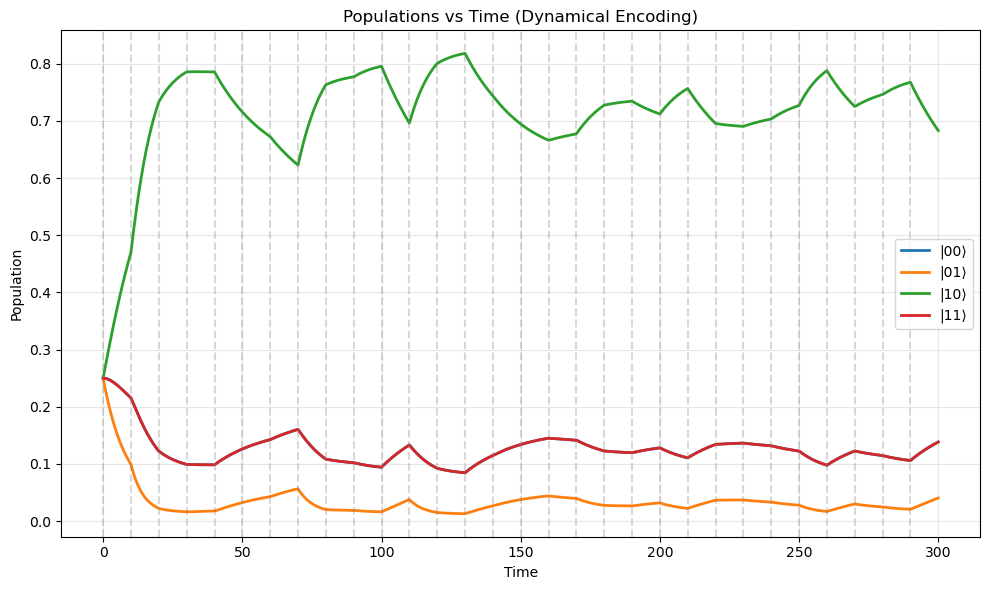


Final populations:
  |00⟩: 0.138308
  |01⟩: 0.040339
  |10⟩: 0.683046
  |11⟩: 0.138308
  Sum: 1.000000


In [ ]:
# ============================================
# DYNAMICAL ENCODING: Using bare_encoding_1d
# ============================================

from dynamical_encodings import bare_encoding_1d, gamma_encoding_1d, dephase_encoding_1d, rich_encoding_1d  

# Time evolution parameters (same convention as before)
dt_dyn = 0.1  # Time step
t_final = 300  # Final time (120 steps * 0.1 = 12.0)
t_dyn = np.linspace(0, t_final, int(t_final/dt_dyn) + 1)
n_total_steps = len(t_dyn) - 1  # Number of evolution steps

chunk = 10*10  # Change params every 30 steps

# Start from a fixed initial state 
#rho_dyn = rho_list["all"]
#rho_dyn = rho_random()
rho_dyn = rho_ss()

# Track all populations
pop_00_dyn = [rho_dyn[0,0].real]
pop_01_dyn = [rho_dyn[1,1].real]
pop_10_dyn = [rho_dyn[2,2].real]
pop_11_dyn = [rho_dyn[3,3].real]
states_dyn = [rho_dyn]

# Set random seed for reproducibility
np.random.seed(42)

# Initialize params (will be set in first iteration)
params_dyn = None

for i in range(n_total_steps):
    # Every 'chunk' steps, encode a new "u" parameter randomly in [-1, 1)
    if i % chunk == 0:
        u = np.random.uniform(-1, 1)
        # Use bare encoding to get full parameter set
        params_dyn = gamma_encoding_1d(u)
        print(f"Step {i} (t={t_dyn[i]:.2f}): u = {u:.3f}")

    # Rebuild H and c_ops from encoded parameters
    H_dyn = build_hamiltonian(params_dyn)
    c_ops_dyn = build_c_ops(params_dyn)

    # Evolve by one small step
    rho_dyn = evolve_step(H_dyn, c_ops_dyn, rho_dyn, dt_dyn)
    states_dyn.append(rho_dyn)
    
    # Extract populations
    pop_00_dyn.append(rho_dyn[0,0].real)
    pop_01_dyn.append(rho_dyn[1,1].real)
    pop_10_dyn.append(rho_dyn[2,2].real)
    pop_11_dyn.append(rho_dyn[3,3].real)

pop_00_dyn = np.array(pop_00_dyn)
pop_01_dyn = np.array(pop_01_dyn)
pop_10_dyn = np.array(pop_10_dyn)
pop_11_dyn = np.array(pop_11_dyn)

# Plot all populations
plt.figure(figsize=(10, 6))

plt.plot(t_dyn, pop_00_dyn, label='|00⟩', linewidth=2)
plt.plot(t_dyn, pop_01_dyn, label='|01⟩', linewidth=2)
plt.plot(t_dyn, pop_10_dyn, label='|10⟩', linewidth=2)
plt.plot(t_dyn, pop_11_dyn, label='|11⟩', linewidth=2)
# Mark when encoding changes
for i in range(0, n_total_steps, chunk):
    plt.axvline(t_dyn[i], color='gray', linestyle='--', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Populations vs Time (Dynamical Encoding)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate sum for final print
pop_sum = pop_00_dyn + pop_01_dyn + pop_10_dyn + pop_11_dyn

print(f"\nFinal populations:")
print(f"  |00⟩: {pop_00_dyn[-1]:.6f}")
print(f"  |01⟩: {pop_01_dyn[-1]:.6f}")
print(f"  |10⟩: {pop_10_dyn[-1]:.6f}")
print(f"  |11⟩: {pop_11_dyn[-1]:.6f}")
print(f"  Sum: {pop_sum[-1]:.6f}")

